In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
plt.style.use('seaborn-bright')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from tqdm import tqdm
from pylab import rcParams


In [2]:
SaleData = pd.read_csv("./SaleData.csv", index_col=0, thousands = ',') # 첫 번째 칼럼을 인덱스로 / 천단위 구분 콤마 생략

In [3]:
df_all = SaleData.copy()

In [4]:
# Data extract for 'Order'
df = df_all.loc[df_all['type'] == 'Order']

# Data Preprocessing

In [5]:
# Change'date/time' Column format and datatype
df.rename(columns={'date/time' : 'Order Date'}, inplace=True)
df['Order Date'] = df['Order Date'].apply(lambda _:datetime.strptime(' '.join(_.split()[0:3]), '%b %d, %Y').strftime('%Y-%m-%d'))
df['Order Date'] = pd.to_datetime((df['Order Date']))

We have 5-year sales data

In [6]:
df['Order Date'].min(), df['Order Date'].max()

(Timestamp('2018-02-01 00:00:00'), Timestamp('2023-02-28 00:00:00'))

Removing columns we don't need

In [7]:
cols = ['settlement id','type','order id','sku','description', 'marketplace', 'account type', 'fulfillment',
 'order city', 'order state', 'order postal', 'tax collection model','product sales', 'product sales tax', 'shipping credits',
 'shipping credits tax', 'gift wrap credits', 'giftwrap credits tax', 'Regulatory Fee', 'Tax On Regulatory Fee',
 'promotional rebates', 'promotional rebates tax', 'marketplace withheld tax', 'selling fees', 'fba fees', 
 'other transaction fees', 'other', 'total']
df.drop(cols, axis=1, inplace=True)
df.isnull().sum()

Order Date    0
quantity      0
dtype: int64

Group by date

In [8]:
pd.to_numeric(df['quantity'])
df = df.groupby('Order Date')['quantity'].sum().to_frame('Order').reset_index()

Indexing with Time Series Data

In [9]:
df = df.set_index('Order Date')
df.index

DatetimeIndex(['2018-02-01', '2018-02-02', '2018-02-03', '2018-02-04',
               '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08',
               '2018-02-09', '2018-02-10',
               ...
               '2023-02-19', '2023-02-20', '2023-02-21', '2023-02-22',
               '2023-02-23', '2023-02-24', '2023-02-25', '2023-02-26',
               '2023-02-27', '2023-02-28'],
              dtype='datetime64[ns]', name='Order Date', length=1853, freq=None)

# Visualizing Orders Time Series Data

In [10]:
# Order 기준을 Week, Month 두 개로 나누어 비교해보자
w = df['Order'].resample('W-MON').mean()
m = df['Order'].resample('MS').mean()

Text(0.5, 0, 'Order Date')

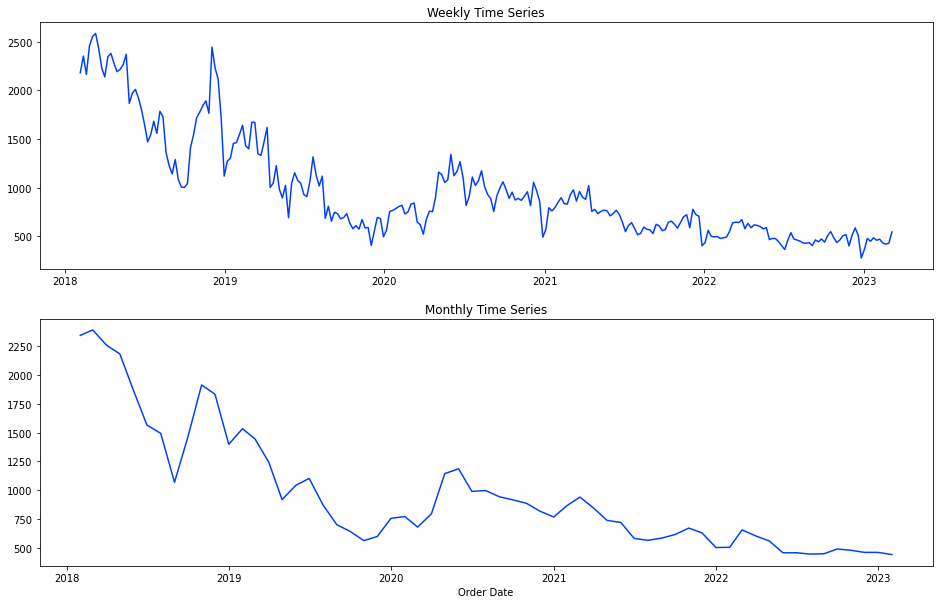

In [11]:
fig, ax = plt.subplots(2,1, figsize=(16,10))

ax[0].plot(w)
ax[1].plot(m)
ax[0].set_title('Weekly Time Series')
ax[1].set_title('Monthly Time Series')
ax[1].set_xlabel('Order Date')


Will use the average daily sales value for that week

# Decomposition of a Time Series

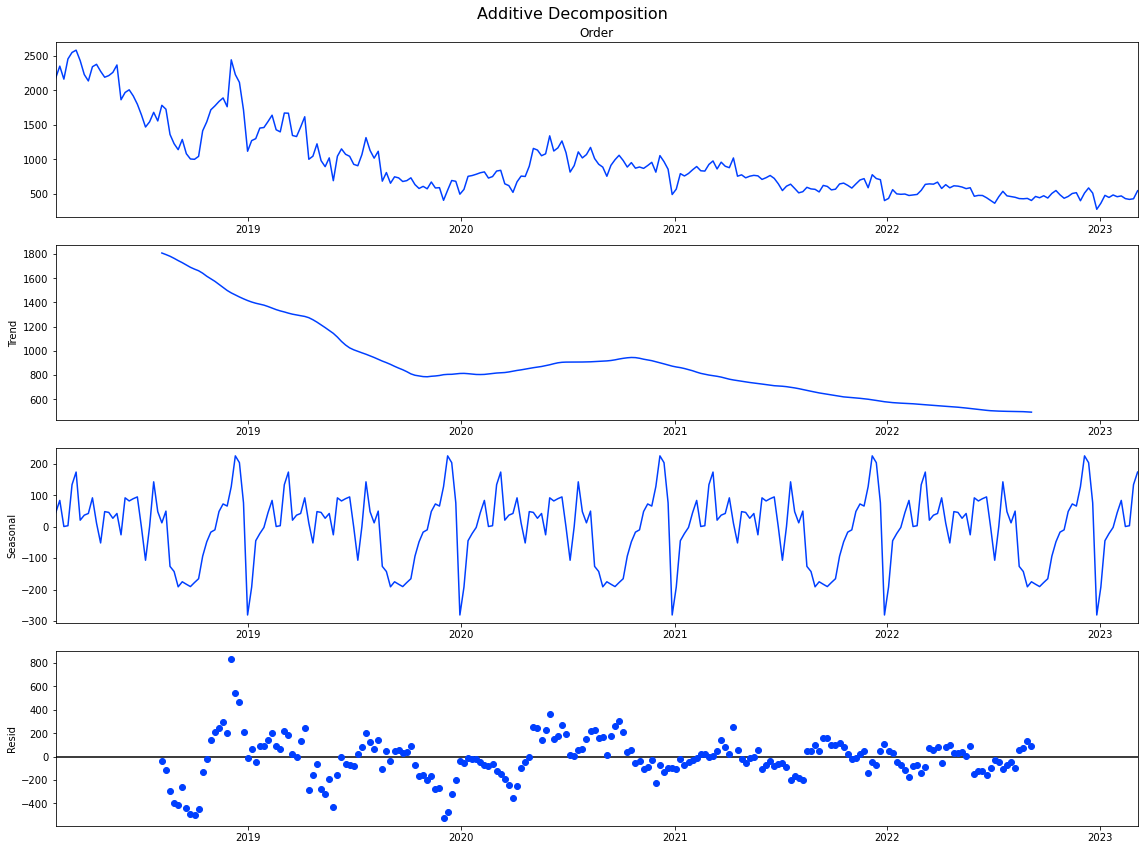

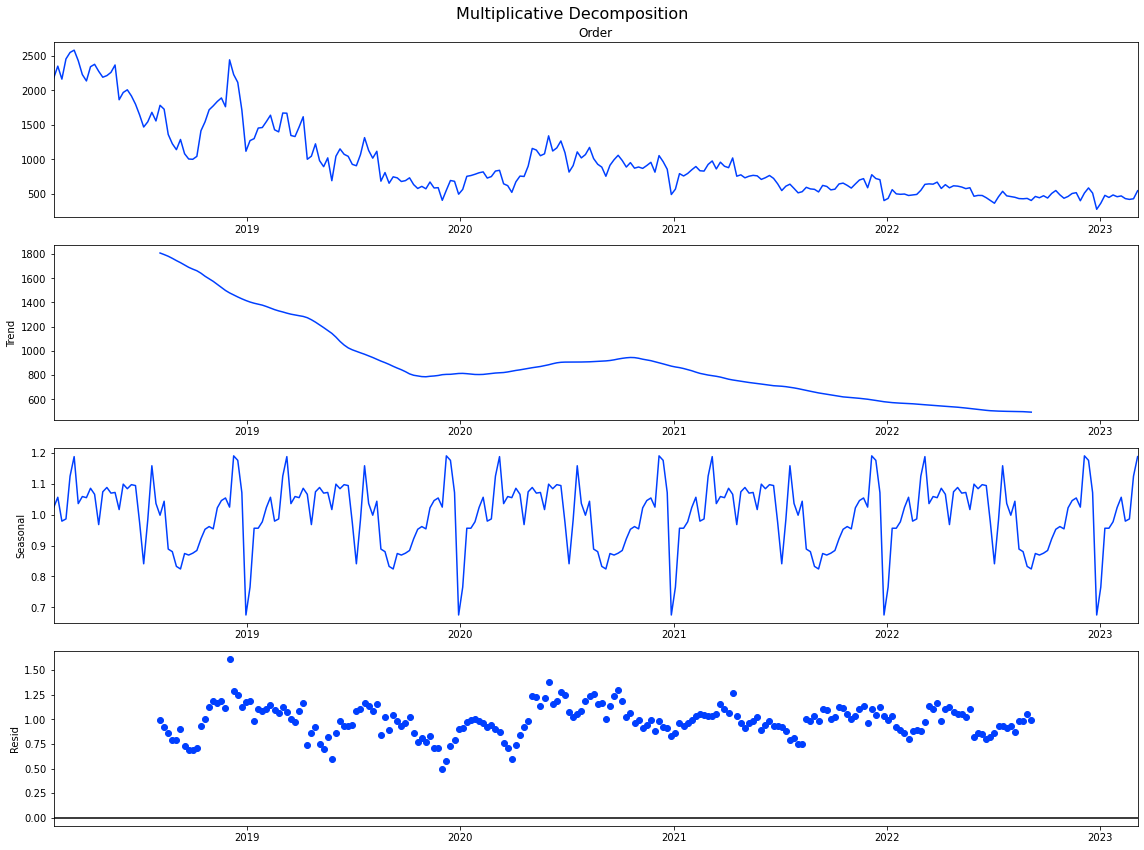

In [12]:
rcParams['figure.figsize'] = 16,12

# Additive Decomposition
additive_decomposition = seasonal_decompose(w, model='additive')

# Multiplicative Decomposition
multiplicative_decomposition = seasonal_decompose(w, model='multiplicative')

# Plot
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout()

multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout()

The residual of multiplicative decomposition is much smaller than additive decomposition, so multiplicative decomposition should be preferred for this series.

# Time series stationary
# let's test a time series stationarity by ACF & ADF & PACF

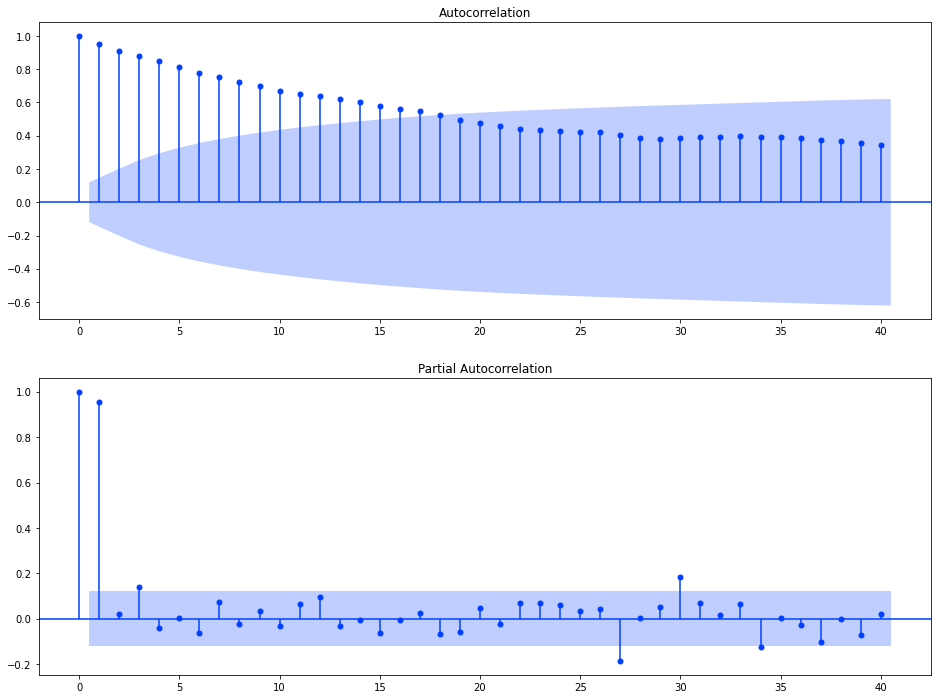

In [13]:
f, ax = plt.subplots(2,1,figsize=(16,12))
a = plot_acf(w, lags=40,ax=ax[0])
b = plot_pacf(w, lags=40, ax=ax[1])

ACF 처음 값이 크고 매우 천천히 감소하고 있고 시차 17 이후에나 신뢰구간에 들어가는 모습, <br>
PACF 는 처음 시차를 제외하고 급격하게 감소하는 모습. 그래서 이 시계열 데이터는 Non-stationary 일 확률이 높음

In [14]:
# ADF
result = adfuller(w)
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -2.4566501461744368
n_lags: 0.1263811303128488
p-value: 0.1263811303128488
Critial Values:
   1%, -3.4554613060274972
Critial Values:
   5%, -2.8725931472675046
Critial Values:
   10%, -2.5726600403359887


p-value 는 0.12로 0.05보다 크고, ADF statistics도 다른 critical value와 비슷한 값을 보임.<br> 
ACF 그래프와 더불어서 Non-stationary 시계열 데이터로 보고 정상 시계열 데이터로 변환 하는 과정이 필요

1. 변동폭이 일정하지 않은 경우 -> 로그 변환<br>
2.추세, 계절성이 존재하는 경우 -> 차분(differencing)<br><br>
이 데이터의 경우에는, 시간에 따라 변동폭이 일정하지 않고, 추세와 계절적 영향이 있으니 로그변환 후 차분 과정이 필요

# 로그변환 & 차분 후 정상성 확인

In [15]:
# 로그변환
w_log = np.log(w)

Text(0.5, 1.0, 'Order after Differencing')

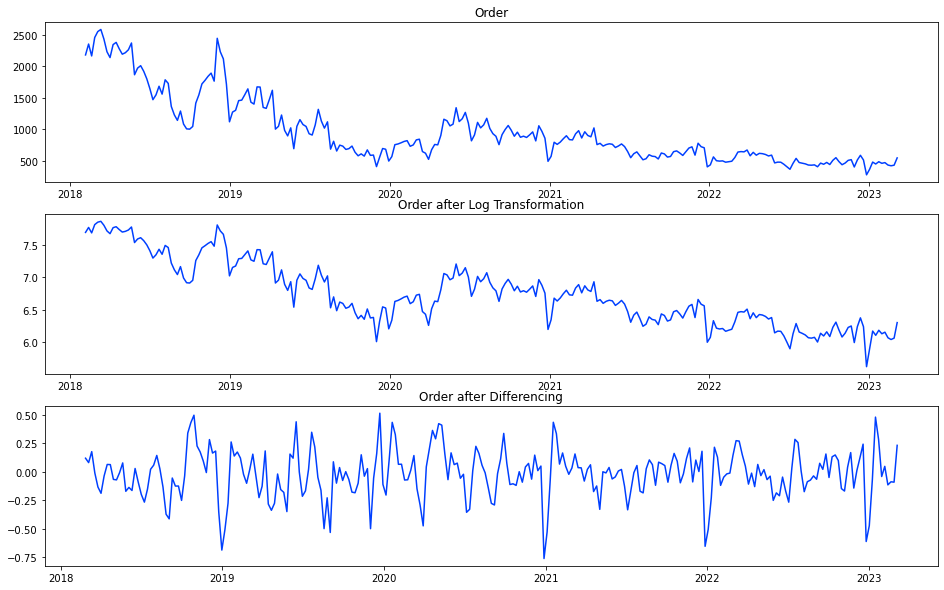

In [16]:
# Let's make a time series stationary

# Differencing 3 times
w_diff = w_log.diff(3)
w_diff = w_diff.dropna()

fig, ax = plt.subplots(3, figsize=(16,10))
ax[0].plot(w)
ax[0].set_title('Order')
ax[1].plot(w_log)
ax[1].set_title('Order after Log Transformation')
ax[2].plot(w_diff)
ax[2].set_title('Order after Differencing')

ADF & ACF & PACF After transformation

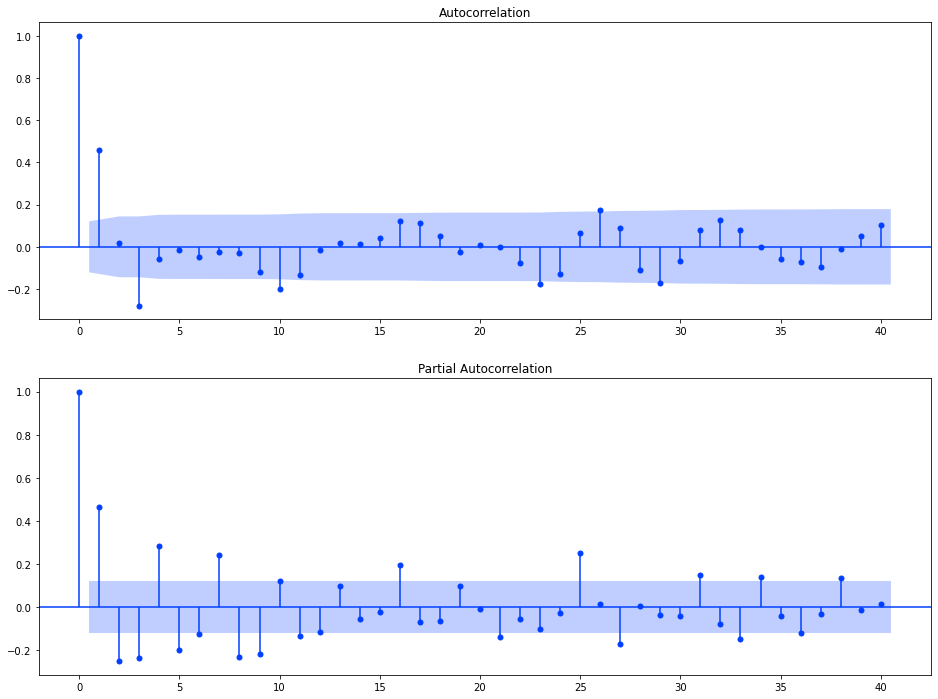

In [17]:
f, ax = plt.subplots(2,1,figsize=(16,12))
a = plot_acf(w_diff, lags=40,ax=ax[0])
b = plot_pacf(w_diff, lags=40, ax=ax[1])

In [18]:
# ADF
result = adfuller(w_diff)
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -3.9521833167736236
n_lags: 0.001682663909495254
p-value: 0.001682663909495254
Critial Values:
   1%, -3.457105309726321
Critial Values:
   5%, -2.873313676101283
Critial Values:
   10%, -2.5730443824681606


ACF 그래프는 자기상관계수가 대체로 0에 가깝고 대부분 신뢰구간 안에 위치함.<br>
ADF 검정 결과 p-value 는 0.0017로 <0.05 : 귀무가설을 기각하여 정상성 변환이 정상적으로 이루어졌음

# ARIMA Modeling

AR(p): PACF 그래프에서 시차가 p를 초과하는 부분에서 상관계수가 0으로 절단되는 부분<br>
MA(q): ACF 그래프에서 차수가 q를 넘는 부분을 0으로 절단. AR 과 MA는 비슷하다.<br>


위에서 3차 차분한 시계열 데이터가 AR(10) 모델과 MA(1) 모델을 따르는 것으로 보임.<br>
ARIMA(10, 3, 1) 모형을 생성할 수 있음.<br>

좀 더 확실한 수치를 찾기 위해서 Grid Search로 맞는 p,d,q를 찾아보자

# Grid Search for ARIMA

In [19]:
p = range(0,11)
d = range(1,4)
q = range(0,2)

pdq = list(itertools.product(p,d,q))

aic = []
params = []

for i in tqdm(pdq, total=len(pdq)):
    try:
        model = SARIMAX(w_diff, order=(i))
        model_fit = model.fit()
        aic.append(round(model_fit.aic,2))
        params.append((i))
    except:
        continue

100%|██████████| 66/66 [00:22<00:00,  3.00it/s]


In [20]:
optimal = [(params[i],j) for i,j in enumerate(aic) if j == min(aic)]
model_opt = ARIMA(w_diff, order = optimal[0][0])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Order   No. Observations:                  263
Model:                ARIMA(10, 1, 1)   Log Likelihood                 120.974
Date:                Fri, 10 Nov 2023   AIC                           -217.947
Time:                        13:54:40   BIC                           -175.127
Sample:                    02-26-2018   HQIC                          -200.737
                         - 03-06-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6885      0.074      9.356      0.000       0.544       0.833
ar.L2         -0.0310      0.075     -0.415      0.678      -0.178       0.116
ar.L3         -0.6664      0.072     -9.225      0.000      -0.808      -0.525
ar.L4          0.5817      0.087      6.676      0.000       0.411       0.752
ar.L5         -0.0461      0.095     -0.487      0.626      -0.232       0.140
ar.L6         -0.4985      0.088     -5.688      0.000      -0.670      -0.327
ar.L7          0.4235      0.083      5.127      0.000       0.262       0.585
ar.L8         -0.0422      0.087     -0.488      0.625      -0.212       0.127
ar.L9         -0.3327      0.074     -4.472      0.000      -0.479      -0.187
ar.L10         0.1310      0.067      1.946      0.052      -0.001       0.263
ma.L1         -0.9883      0.030    -32.558      0.000      -1.048      -0.929
sigma2         0.0230      0.002     12.758      0.000       0.019       0.027
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                76.20
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                            -0.85
Prob(H) (two-sided):                  0.20   Kurtosis:                         5.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Grid Search 결과 최소의 AIC값을 갖는 최적의 파라미터는 (10,1,1)이 나왔다

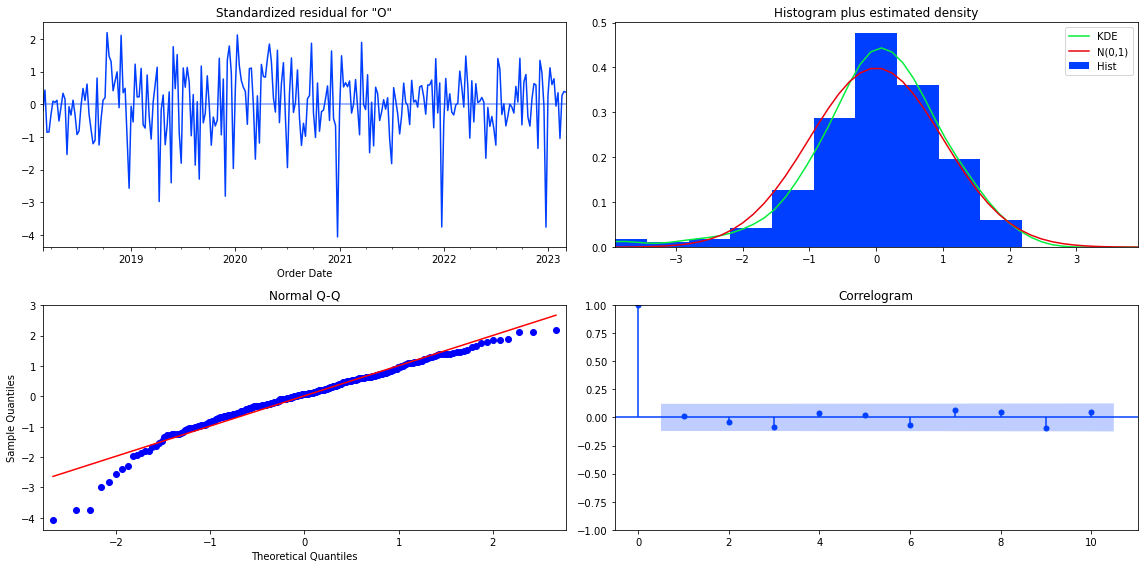

In [21]:
a = model_opt_fit.plot_diagnostics(figsize=(16,8))
plt.tight_layout()

Model Diagnostics를 돌려봤을 때 모델의 잔차(residual)가 정규 분포를 따르는 것을 볼 수 있다.<br>
잔차가 정규 분포를 따른다는 것은 모델이 데이터의 패턴을 잘 설명하고 예측하는 데 성공했다는 것을 의미한다.

# Validating forecasts 

실제 값과 모델을 이용한 예측값을 동시에 그래프를 그려서 예측이 잘 수행되는지 확인해보자

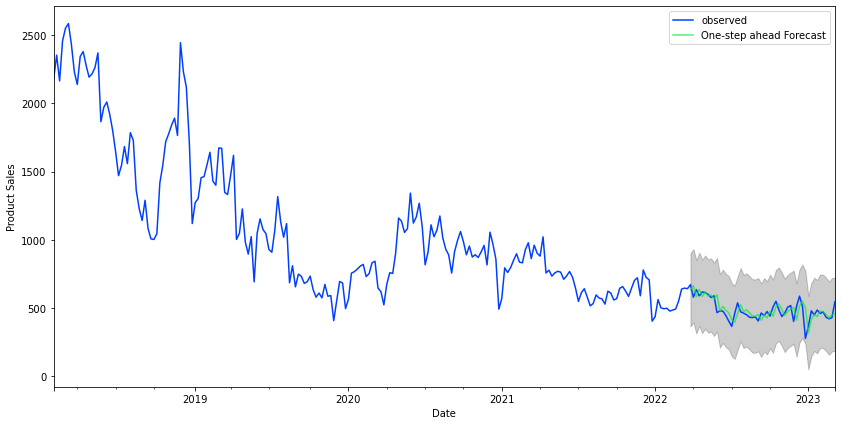

In [22]:
model = ARIMA(w, order = optimal[0][0])
result = model.fit()
pred = result.get_prediction(start='2022-03-28',dynamic=False)
pred_ci = pred.conf_int()

ax = w.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Product Sales')
plt.legend()

실제 값 예측은 잘 수행하는 것으로 보인다

# 모델 성능 평가
# MSE, RSME, MAPE

In [23]:

forecasted = pred.predicted_mean
real = w['2022-03-28':]

mse = ((forecasted - real) ** 2).mean()
rmse = np.sqrt(mse)

def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))
print('The Mean Absolute Percentage Error of our forecasts is {}'.format(round(MAPEval(forecasted, real), 2)))

The Mean Squared Error of our forecasts is 3494.52
The Root Mean Squared Error of our forecasts is 59.11
The Mean Absolute Percentage Error of our forecasts is 10.0


약 10%의 오차로 판매량을 예측하는 것으로 나타났다.

# Forecasting with ARIMA Model
# 실제 값이 아닌 미래 값을 예측해보자 

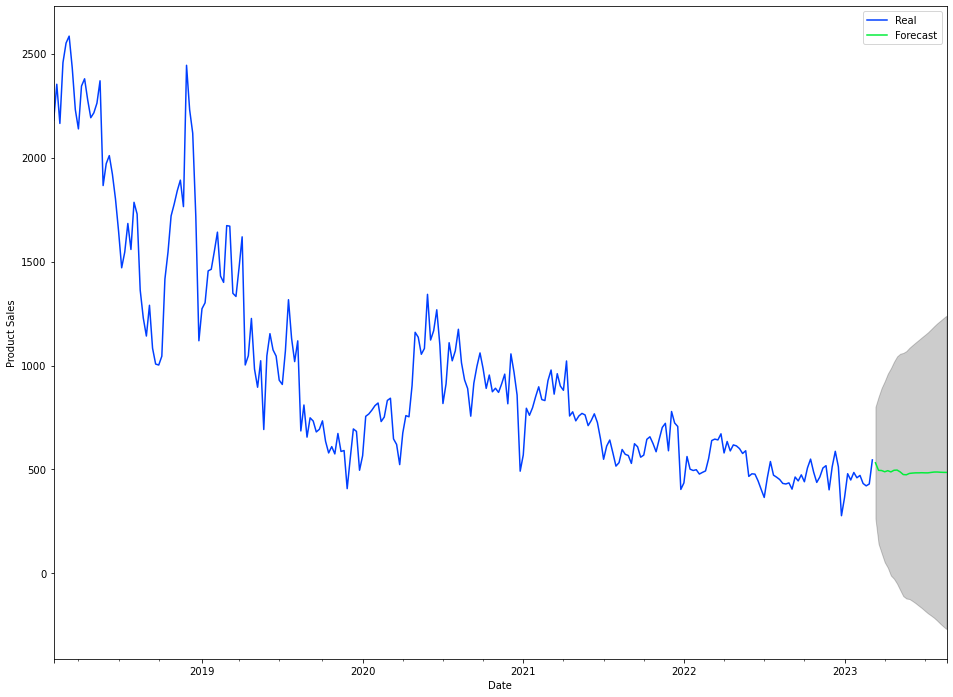

In [24]:
pred_f = result.get_forecast(steps=24)
pred_f_ci = pred_f.conf_int()

ax = w.plot(label = 'Real')
pred_f.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_f_ci.index,
               pred_f_ci.iloc[:, 0],
               pred_f_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Product Sales')
plt.legend()

# 한 눈에 봐도 예측 수행을 잘 못하는 것으로 보인다
# 가진 데이터가 계절성을 띄고 있으니 SARIMAX 모델을 이용하여 다시 예측을 해보자
# Grid Search 방법으로 최적의 파라미터 값을 찾아보자

In [30]:
p = range(0,2)
d = range(1,4)
q = range(0,2)
m = 52 # 계절성이 12개월 = 52주 마다 나타나므로 m = 52

pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2], m) for x in list(itertools.product(p,d,q))]

aic = []
params = []

with tqdm(total = len(pdq) * len(seasonal_pdq)) as pg:
    for i in pdq:
        for j in seasonal_pdq:
            pg.update(1)
            try:
                model = SARIMAX(w_diff, order=(i), seasonal_order = (j))
                model_fit = model.fit()
                aic.append(round(model_fit.aic,2))
                params.append((i,j))
            except:
                continue

100%|██████████| 144/144 [30:48<00:00, 12.84s/it]


In [31]:
optimal = [(params[i],j) for i,j in enumerate(aic) if j == min(aic)]
model_opt = SARIMAX(w_diff, order = optimal[0][0][0], seasonal_order = optimal[0][0][1])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Order   No. Observations:                  263
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood                  66.831
Date:                            Fri, 10 Nov 2023   AIC                           -125.661
Time:                                    14:45:17   BIC                           -112.273
Sample:                                02-26-2018   HQIC                          -120.249
                                     - 03-06-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5365      0.062      8.602      0.000       0.414       0.659
ma.L1         -0.9979      0.356     -2.805      0.005      -1.695      -0.301
ma.S.L52      -0.6721      0.157     -4.294      0.000      -0.979      -0.365
sigma2         0.0262      0.010      2.644      0.008       0.007       0.046
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                54.82
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 모델 성능 평가

In [32]:
forecasted = pred.predicted_mean
real = w['2022-03-28':]

mse = ((forecasted - real) ** 2).mean()
rmse = np.sqrt(mse)

def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))
print('The Mean Absolute Percentage Error of our forecasts is {}'.format(round(MAPEval(forecasted, real), 2)))

The Mean Squared Error of our forecasts is 3828.97
The Root Mean Squared Error of our forecasts is 61.88
The Mean Absolute Percentage Error of our forecasts is 10.27


약 10.27%의 오차로 판매량을 예측하는 것으로 나타났다.

# Validating forecasts

Text(0, 0.5, 'Orders')

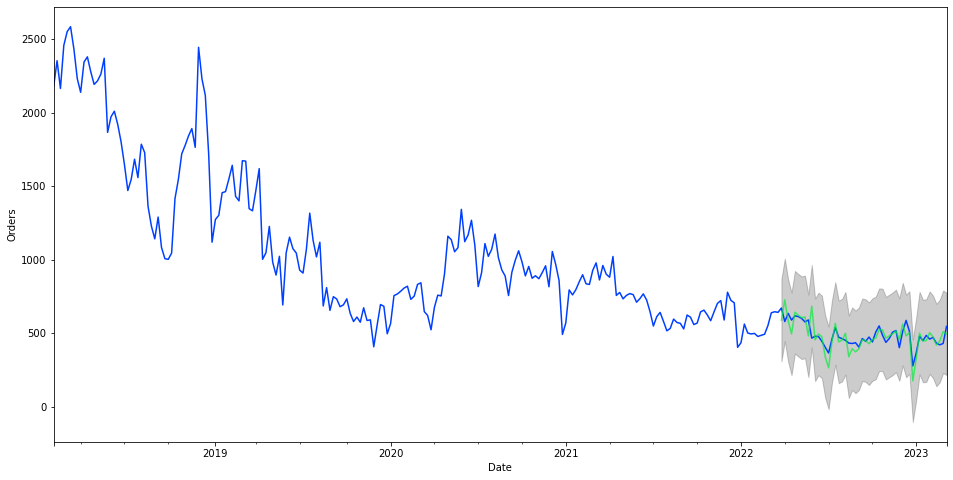

In [33]:
model = SARIMAX(w, order=optimal[0][0][0], seasonal_order=optimal[0][0][1])
result = model.fit()
pred = result.get_prediction(start='2022-03-28',dynamic=False)
pred_ci = pred.conf_int()

ax = w.plot(label = 'observed', figsize=(16,8))
pred.predicted_mean.plot(ax=ax, label='Forecast',alpha=.7)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
                color='k',alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Orders')

실제 값과 예측값을 비교해봤을 때 정확하진 않지만 비교적 잘 예측을 잘 수행하는 것으로 보인다

# SARIMAX 모델로 미래 값을 예측해보자

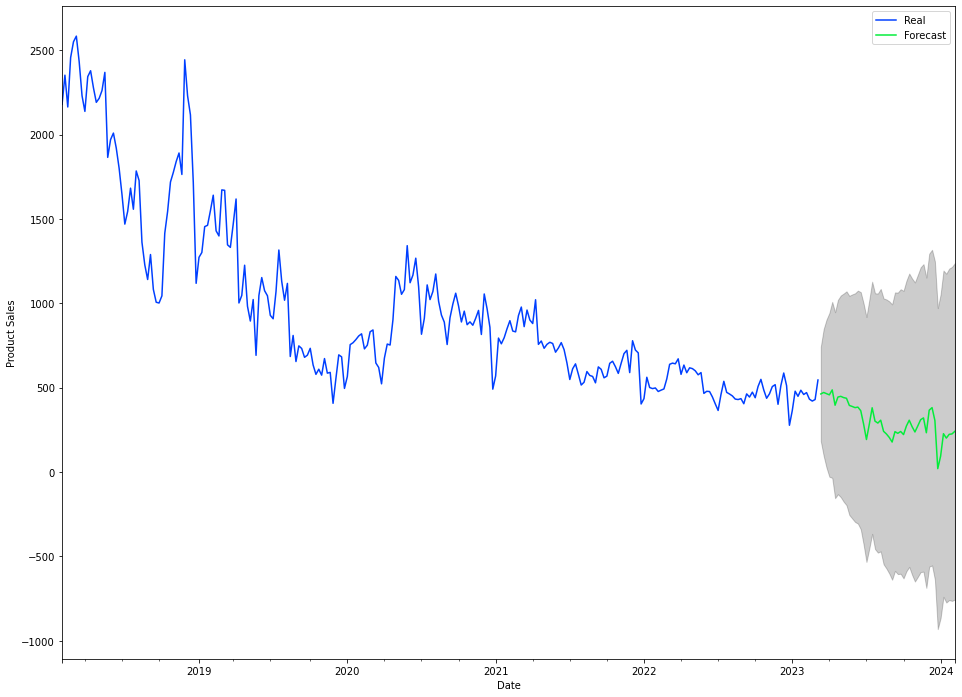

In [34]:
pred_f = result.get_forecast(steps=48)
pred_f_ci = pred_f.conf_int()

ax = w.plot(label = 'Real')
pred_f.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_f_ci.index,
               pred_f_ci.iloc[:, 0],
               pred_f_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Product Sales')
plt.legend()

# ARIMA 모델에 비해서 미래 값 예측을 잘 수행하는 것으로 보인다
# SARIMAX 모델은 계절성이 포함된 데이터, 그 계절성을 고려하여 시계열 데이터를 모델링하고 예측하는 데 더욱 유용하게 사용될 수 있다